In [1]:
#####################################
### Import the relevant libraries ###
#####################################

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import psutil
from pathlib import Path
import os
import time

2024-11-04 00:19:44.570844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730679584.580384    5188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730679584.583291    5188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 00:19:44.594031: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Memory usage
def log_memory():
    #Log memory usage
    process = psutil.Process()
    print(f"{process.memory_info().rss / 1000 / 1000}mb")  # in mb 
log_memory()

617.644032mb


***
# **DATA**

In [3]:
PATH = Path("dataset") / "GTSRB"
PATH_TRAIN = PATH / "Training"

def load_dataset():
    train_directories = [PATH_TRAIN / subdir for subdir in os.listdir(PATH_TRAIN) if os.path.isdir(PATH_TRAIN / subdir)]
    train_directories = sorted(train_directories)
    #Test data is unlabelled??? -> Just split off training data for testing
    data = [[(cv2.cvtColor(cv2.imread(path / img), cv2.COLOR_BGR2RGB),path.name) for img in os.listdir(path) if img.endswith(".ppm")] for path in train_directories]
    X = [[img[0] for img in row] for row in data]
    y = [[int(img[1]) for img in row] for row in data]
    #Flatten 2d structure   
    X = [img for row in X for img in row]
    y = np.array([label for row in y for label in row])
    return (X[:5000],y[:5000])
X,y = load_dataset()

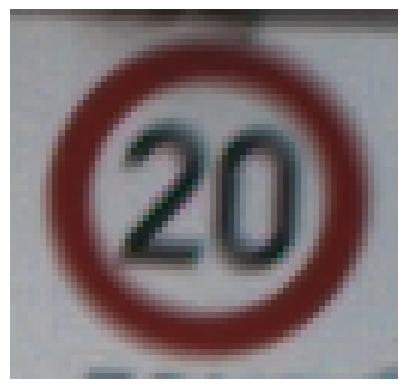

In [4]:
def show_image(img):
    plt.imshow(img)
    plt.axis('off') 
    plt.show()
show_image(X[2])

In [5]:
#Transform images to same size, normalise colour space
_N = 32

def transform_image(img):
    return tf.image.resize(img,[_N,_N]) / 255.0

X = list(map(transform_image,X))
#Convert to numpy array
X = np.array(X)

I0000 00:00:1730679586.829461    5188 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


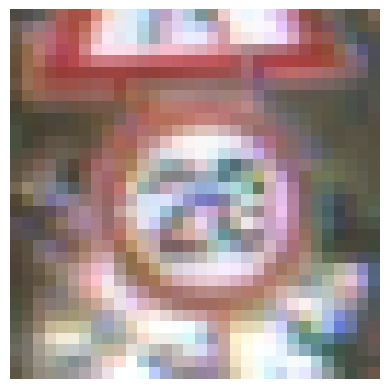

In [6]:
#Compare to see if we fucked up images
show_image(X[0])
print()

In [7]:
print(X.shape)
print(y.shape)

(5000, 32, 32, 3)
(5000,)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 32, 32, 3)
(1000, 32, 32, 3)
(4000,)
(1000,)


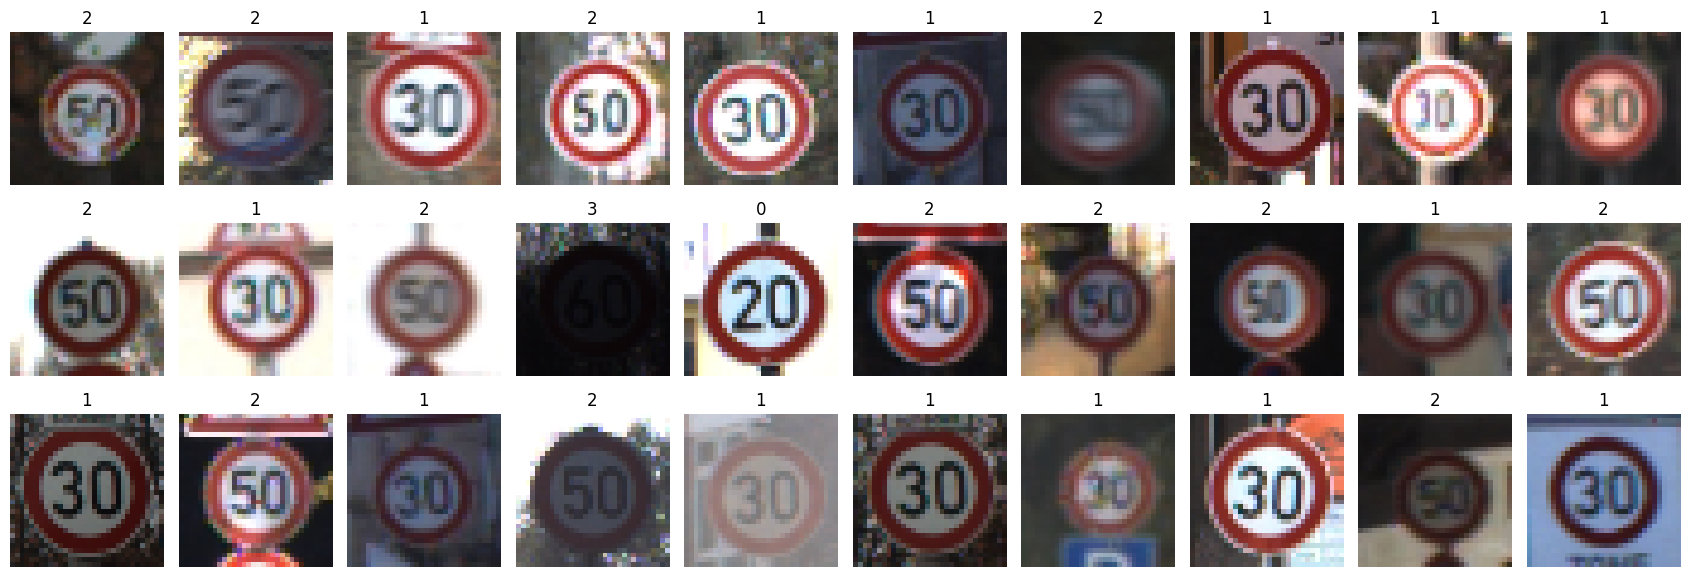

In [10]:
###############################
### Visualise some examples ###
###############################

def display_some_examples(examples, labels, n_examples):
    plt.figure(figsize=(17,6))

    for i in range(n_examples):
        idx = np.random.randint(0, examples.shape[0] - 1)
        img = examples[idx]
        label = labels[idx]

        plt.subplot(3, 10, i + 1)
        plt.title(str(label))
        plt.axis('off') 
        plt.imshow(img, cmap='gray')

    plt.tight_layout()
    plt.show()

display_some_examples(X_train, y_train, n_examples=30)

***
# **BASE TRAINING**

In [11]:
##########################
### Set some variables ###
##########################

input_size = _N * _N * 3
batch_size = 64
epochs = 6
n_classes = np.unique(y).shape[0]
epsilon = 0.3
alpha = 0.1
num_iter = 10
print(n_classes)

4


In [12]:
log_memory()

1527.803904mb


In [13]:
#Flatten 
#print(X_train.shape)
#X_train = X_train.reshape(X_train.shape[0], input_size)
#X_test = X_test.reshape(X_test.shape[0], input_size)
#print(X_train.shape)

In [14]:
log_memory()

1527.803904mb


In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [16]:
log_memory()

1626.0423680000001mb


In [17]:
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [24]:
########################
### Define the model ###
########################

def get_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(_N,_N,3)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(n_classes))

    print(model.summary())
    return model
model = get_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,180 (477.27 KB)

 Trainable params: 122,180 (477.27 KB)

 Non-trainable params: 0 (0.00 B)

None


In [29]:
##########################
### Train a base model ###
##########################


model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)



Epoch 1/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5149 - loss: 1.0208 - val_accuracy: 0.7190 - val_loss: 0.8301
Epoch 2/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7863 - loss: 0.6717 - val_accuracy: 0.8540 - val_loss: 0.4232
Epoch 3/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9026 - loss: 0.3057 - val_accuracy: 0.9150 - val_loss: 0.2222
Epoch 4/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1898 - val_accuracy: 0.9600 - val_loss: 0.1344
Epoch 5/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0801 - val_accuracy: 0.9500 - val_loss: 0.1408
Epoch 6/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9730 - loss: 0.0816 - val_accuracy: 0.9770 - val_loss: 0.0883


In [30]:
###############################################################
### Define the precision, recall, F1 and ROC curve function ###
###############################################################

def print_metrics(model, x, y, c):
    # Get predicted probabilities for all classes
    y_pred_prob = model.predict(x)

    # Get predicted class labels (highest probability class)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    # Calculate precision, recall, and F1-score (using macro average)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    # Binarize the output (needed for multiclass ROC)
    # This turns the class labels into a one-vs-rest binary format
    y_test_bin = label_binarize(y, classes=np.arange(c))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(c):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(6, 5))
    for i in range(c):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Precision (macro): 0.9812
Recall (macro): 0.9483
F1-score (macro): 0.9636


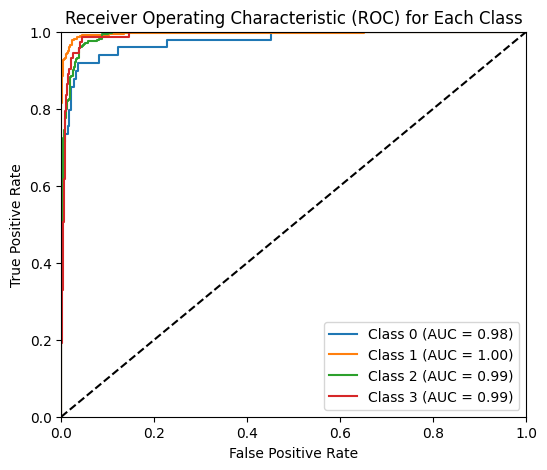

In [31]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model, X_test, y_test, n_classes)

In [ ]:
######################################
### Define the PGD attack function ###
######################################

def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """Perform PGD attack on a batch of images.
    
    Args:
        model: Trained Keras model.
        x: Input images (batch).
        y: True labels (batch).
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of PGD iterations.

    Returns:
        Adversarial examples.
    """
    # Make a copy of the input to avoid modifying the original data
    x_adv = tf.identity(x)

    # Iterate PGD for num_iter steps
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)  # Watch x_adv for gradient computation
            predictions = model(x_adv)  # Forward pass
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)  # Loss w.r.t. true label

        # Compute the gradients of the loss w.r.t. the input
        gradients = tape.gradient(loss, x_adv)
        
        # Perform gradient ascent step in the direction that maximizes the loss
        perturbations = tf.sign(gradients)  # Use the sign of the gradients (FGSM-like step)
        x_adv = x_adv + alpha * perturbations  # Update the adversarial example
        
        # Project the adversarial example to ensure it's within epsilon-ball of the original image
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        
        # Ensure the adversarial examples are within the valid input range [0, 1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    
    return x_adv

In [ ]:
############################################################################
### Define the function to visualize the original and adversarial images ###
############################################################################

def original_vs_adversarial_images(x_og, y_og, x_adv, y_pred):
    plt.figure(figsize=(17, 4))

    # Counter for how many images to display
    display_count = 0

    for i in range(len(x_og)):
        # Check if the class changes after the attack
        if y_og[i] != y_pred[i]:
            # Original images (reshape from (28, 28, 1) to (28, 28))
            original_image = x_og[i].reshape(28, 28)
            
            # Adversarial images (reshape from (28, 28, 1) to (28, 28))
            adversarial_image = x_adv[i].numpy().reshape(28, 28)

            # Plot original images
            plt.subplot(2, 10, display_count + 1)
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Orig: {y_og[i]}')

            # Plot adversarial images
            plt.subplot(2, 10, display_count + 11)
            plt.imshow(adversarial_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Adv: {y_pred[i]}')

            # Increment the display counter
            display_count += 1
            
            # Stop after displaying 10 images
            if display_count == 10:
                break

    plt.tight_layout()
    plt.show()

In [ ]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample = X_test
y_test_sample = y_test

# Generate adversarial examples
x_test_adv = pgd_attack(model_base, x_test_sample, y_test_sample, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv = np.argmax(model_base.predict(x_test_adv), axis=1)
accuracy_adv = np.mean(y_pred_adv == y_test_sample)

print(f'Accuracy on adversarial examples: {accuracy_adv:.4f}')
original_vs_adversarial_images(x_test_sample, y_test_sample, x_test_adv, y_pred_adv)

***
# **ADVERSARIAL TRAINING**

In [ ]:
################################################
### Define the adversarial training function ###
################################################

def adversarial_training(model, train_dataset, optimizer, loss_fn, epsilon, alpha, num_iter, epochs):
    """
    Performs adversarial training with PGD adversarial examples.
    
    Args:
    model: The model to train.
    train_dataset: A TensorFlow dataset for training.
    optimizer: The optimizer for model training.
    loss_fn: Loss function to use.
    epsilon: Maximum perturbation for PGD (epsilon).
    alpha: Step size for PGD.
    num_iter: Number of PGD iterations for generating adversarial examples.
    epochs: Number of training epochs.
    
    Returns:
    model: The trained model.
    """
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # Accuracy metric for the epoch
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        
        # Training loop over batches
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples using PGD
                x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
                
                # Combine original and adversarial examples for training
                combined_x = tf.concat([x_batch, x_adv_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)
                
                # Forward pass
                logits = model(combined_x, training=True)
                
                # Compute the loss
                loss = loss_fn(combined_y, logits)
            
            # Backpropagation
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training accuracy metric
            train_acc_metric.update_state(combined_y, logits)

        # End of epoch: calculate and print accuracy and epoch time
        train_acc = train_acc_metric.result().numpy()

        # Evaluate on test dataset (for validation accuracy)
        test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_test_batch, y_test_batch in test_dataset:
            test_logits = model(x_test_batch, training=False)
            test_acc_metric.update_state(y_test_batch, test_logits)
        test_acc = test_acc_metric.result().numpy()

        print(f"Train loss: {loss.numpy():.4f} -|- Train acc: {train_acc:.4f} -|- Test acc: {test_acc:.4f} -|- Time: {(time.time() - start_time):.2f}s")
    
    return model

In [ ]:
##################################
### Train an adversarial model ###
##################################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_adv = get_model(input_size)
model_adv = adversarial_training(model_adv, train_dataset, optimizer, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter, epochs=epochs)

In [ ]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model_adv, X_test, y_test, n_classes)

In [ ]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample_ADV = X_test
y_test_sample_ADV = y_test

# Generate adversarial examples
x_test_adv_ADV = pgd_attack(model_adv, x_test_sample_ADV, y_test_sample_ADV, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv_ADV = np.argmax(model_adv.predict(x_test_adv_ADV), axis=1)
accuracy_adv_ADV = np.mean(y_pred_adv_ADV == y_test_sample_ADV)

print(f'Accuracy on adversarial examples: {accuracy_adv_ADV:.4f}')
original_vs_adversarial_images(x_test_sample_ADV, y_test_sample_ADV, x_test_adv_ADV, y_pred_adv_ADV)